### Modeling: 결과를 산출하는 공식을 제작하는 과정, 공식의 계수(Intercepter, Coefficient)를 찾아내는 과정

In [33]:
import warnings
warnings.filterwarnings("ignore")

import random
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

In [34]:
# 전처리가 완료된 csv 파일 읽기
X_train = pd.read_csv('./data/x_train.csv')
Y_train = pd.read_csv('./data/y_train.csv')
x_test = pd.read_csv('./data/x_test.csv')

In [35]:
# LightGBM package 설치
!pip install lightgbm==2.3.1

In [36]:
import lightgbm as lgb
print(lgb.__version__)

2.3.1


In [37]:
from sklearn.model_selection import train_test_split # 홀드 아웃
from sklearn.model_selection import KFold # K-폴드 교차 검증

In [38]:
x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size=0.2)
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)

(712, 10)
(712, 1)
(179, 10)
(179, 1)


In [39]:
# LightGBM용 데이터셋 작성
categories = ["Embarked", "Pclass", "Sex","honorific","alone"] # 카테고리
lgb_train = lgb.Dataset(x_train, y_train, categorical_feature=categories)
lgb_eval = lgb.Dataset(x_valid, y_valid,  categorical_feature=categories, reference=lgb_train)

In [40]:
lgbm_params = { # 하이퍼 파라미터
    "objective":"binary", # 이항 분류       
    "random_seed":1234,
}

In [41]:
# 훈련
# 부트스트랩: 동일한 크기의 데이터를 랜덤 복원 추출
model_lgb = lgb.train(lgbm_params,         # 하이퍼 파라미터
                      lgb_train,           # 훈련 데이터
                      valid_sets=lgb_eval, # 평가 데이터
                      num_boost_round=100, # 학습 횟수, boost: 부트스트랩
                      early_stopping_rounds=5, # 오차 증가 인정 횟수
                      verbose_eval=10)     # 학습 결과의 표시 빈도
# [15] valid_0's binary_logloss: 0.512474:
# 15번째 학습이 가장 우수한 결과, 손실이 가장 적음

Training until validation scores don't improve for 5 rounds
[10]	valid_0's binary_logloss: 0.47041
[20]	valid_0's binary_logloss: 0.419673
[30]	valid_0's binary_logloss: 0.403952
Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.403438


In [42]:
# 결과(y_train)를 예측하는 훈련 과정중에 나타난 각 변수의 중요도 확인
print(model_lgb.feature_importance())
print(x_train.columns) # 'Fare'가 가장 중요

[ 55  25 298  16  30 373  26   8  43   8]
Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked',
       'honorific', 'family_num', 'alone'],
      dtype='object')


In [43]:
# index=x_train.columns: 항목 명
importance = pd.DataFrame(model_lgb.feature_importance(), index=x_train.columns, columns=["importance"]).sort_values(by="importance",ascending =True)
importance.head()

,importance
honorific,8
alone,8
SibSp,16
Sex,25
Embarked,26


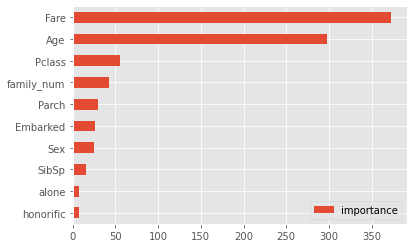

In [44]:
importance.plot.barh()
plt.show()

In [45]:
# 검증, 사망: 0 ~ 1: 생존 
y_pred = model_lgb.predict(x_valid, num_iteration=model_lgb.best_iteration)
print(y_pred.shape)
print(type(y_pred))
print(y_pred)

(179,)
<class 'numpy.ndarray'>
[0.95692177 0.16856478 0.27073274 0.10092573 0.97317663 0.95831106
 0.68895279 0.29468227 0.49818778 0.35302808 0.78035005 0.14358429
 0.5257045  0.189039   0.0601553  0.97352212 0.10885308 0.43832206
 0.1393866  0.13030172 0.07944116 0.95569269 0.91696778 0.27143574
 0.96994579 0.95736851 0.12147631 0.07012654 0.7054672  0.71312318
 0.18329266 0.95715237 0.07341951 0.4777848  0.25309838 0.19549018
 0.82237472 0.07907935 0.69046839 0.24710951 0.97446969 0.6299406
 0.04414324 0.22361678 0.40616642 0.73927506 0.7104195  0.15884801
 0.96228708 0.85855449 0.07126786 0.35777953 0.23291963 0.12147631
 0.97603167 0.95864297 0.08898626 0.08477148 0.78007311 0.17876723
 0.32623958 0.44821116 0.0667529  0.05069093 0.69046839 0.06316039
 0.54183497 0.21092438 0.95690762 0.12344047 0.31362236 0.25309838
 0.04384576 0.28556161 0.23291963 0.15743631 0.13731898 0.97470097
 0.25309838 0.96959916 0.07598038 0.04980934 0.56717266 0.41679084
 0.05442505 0.21409376 0.0667529

In [46]:
# 훈련 데이터는 정답을 알고 있는 상황
from sklearn.metrics import accuracy_score
accuracy_score(y_valid, np.round(y_pred))

0.8324022346368715

In [47]:
lgbm_params = { # 하이퍼 파라미터 변경 시도
    "objective":"binary",
    "max_bin":331,     # 분기 1개에 들어가는 데이터의 최댓값
    "num_leaves": 20,  # 하나의 결정 트리에 포함되는 최대 노드 갯수
    "min_data_in_leaf": 57, # 결정 트리중 하나의 가지당 할당되는 데이터 수
    "andom_seed":1234,
}

In [48]:
# 훈련
# 부트스트랩: 동일한 크기의 데이터를 랜덤 복원 추출
lgb_train = lgb.Dataset(x_train, y_train, categorical_feature=categories)
lgb_eval = lgb.Dataset(x_valid, y_valid,  categorical_feature=categories, reference=lgb_train)

model_lgb = lgb.train(lgbm_params,         # 하이퍼 파라미터
                      lgb_train,           # 훈련 데이터
                      valid_sets=lgb_eval, # 평가 데이터
                      num_boost_round=200, # 학습 횟수, boost: 부트스트랩
                      early_stopping_rounds=30, # 오차 증가 인정 횟수
                      verbose_eval=10)     # 학습 결과의 표시 빈도
# [21] valid_0's binary_logloss:
# 0.500305 21번째 학습이 가장 우수한 결과, 손실이 가장 적음

Training until validation scores don't improve for 30 rounds
[10]	valid_0's binary_logloss: 0.476238
[20]	valid_0's binary_logloss: 0.431614
[30]	valid_0's binary_logloss: 0.417589
[40]	valid_0's binary_logloss: 0.4087
[50]	valid_0's binary_logloss: 0.409561
[60]	valid_0's binary_logloss: 0.410789
[70]	valid_0's binary_logloss: 0.411001
Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.408348


In [49]:
y_pred = model_lgb.predict(x_valid, num_iteration=model_lgb.best_iteration)
accuracy_score(y_valid, np.round(y_pred))

0.8268156424581006

In [50]:
preds_int = (y_pred > 0.5).astype(int) # 평균 > 0.5: 1, 0.5 <= 평균: 0 
preds_int

array([1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 0])

In [51]:
y_test = model_lgb.predict(x_test, num_iteration=model_lgb.best_iteration)
accuracy_score(y_valid, np.round(y_pred))

0.8268156424581006

In [52]:
y_test

array([0.07161789, 0.34242305, 0.07274806, 0.12939728, 0.45328676,
       0.14702923, 0.44816719, 0.26335738, 0.74405302, 0.09094024,
       0.08141409, 0.15565179, 0.96743542, 0.0468691 , 0.93367576,
       0.96306462, 0.11463166, 0.16470548, 0.52199129, 0.48833435,
       0.37943084, 0.61216303, 0.96150284, 0.47089457, 0.82931341,
       0.04141516, 0.97361372, 0.17498562, 0.36984813, 0.17187265,
       0.0468691 , 0.17506539, 0.32536572, 0.32536572, 0.39675168,
       0.19627811, 0.43897656, 0.37757223, 0.08592656, 0.32637458,
       0.050796  , 0.42960122, 0.04090213, 0.92169593, 0.93367576,
       0.14441743, 0.34088684, 0.08102602, 0.93419322, 0.70995764,
       0.41857796, 0.16504794, 0.7528841 , 0.86246782, 0.21716829,
       0.29785868, 0.07324218, 0.14337212, 0.13080493, 0.95362595,
       0.12549951, 0.21608496, 0.14697946, 0.69264752, 0.77425599,
       0.96112198, 0.72338626, 0.28362981, 0.42001523, 0.81096344,
       0.69883307, 0.08639337, 0.5484705 , 0.38886585, 0.96288

In [53]:
tests_int = (y_test > 0.5).astype(int) # 평균 > 0.5: 1, 0.5 <= 평균: 0 
tests_int

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [54]:
submission = pd.read_csv('./data/gender_submission.csv')
submission['Survived'] = tests_int # 기존에 변수가 있으면 덮어써짐.
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [55]:
# Kaggle로 전송하는 파일명은 자유롭게 지정 가능
submission.to_csv('./submission/titanic_submission01.csv', index=False)

### 교차 검증(참고)

In [56]:
folds = 3

kf = KFold(n_splits=folds)

cnt = 0
for train_index, val_index in kf.split(X_train):
    cnt = cnt + 1
    print('▶ cnt:', cnt)
    print('----- train_index -----')
    print(train_index)
    print('----- val_index -----')
    print(train_index)

▶ cnt: 1
----- train_index -----
[297 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313 314
 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332
 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350
 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366 367 368
 369 370 371 372 373 374 375 376 377 378 379 380 381 382 383 384 385 386
 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401 402 403 404
 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422
 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440
 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458
 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476
 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494
 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512
 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530
 531 532 533 534 5

In [57]:
models = []

# 훈련과 검증 index를 이용하여 관측치를 분할
for train_index, val_index in kf.split(X_train):
    x_train = X_train.iloc[train_index]
    x_valid = X_train.iloc[val_index]
    y_train = Y_train.iloc[train_index]
    y_valid = Y_train.iloc[val_index]
        
    lgb_train = lgb.Dataset(x_train, y_train, categorical_feature=categories)
    lgb_eval = lgb.Dataset(x_valid, y_valid, categorical_feature=categories, reference=lgb_train)    
    
    model_lgb = lgb.train(lgbm_params, 
                          lgb_train, 
                          valid_sets=lgb_eval, 
                          num_boost_round=200,
                          early_stopping_rounds=30,
                          verbose_eval=10,
                         )    
    
    y_pred = model_lgb.predict(x_valid, num_iteration=model_lgb.best_iteration)
    print(accuracy_score(y_valid, np.round(y_pred)))
    
    models.append(model_lgb) # 훈련된 lightgbm 모델 저장

Training until validation scores don't improve for 30 rounds
[10]	valid_0's binary_logloss: 0.504307
[20]	valid_0's binary_logloss: 0.473861
[30]	valid_0's binary_logloss: 0.458723
[40]	valid_0's binary_logloss: 0.452203
[50]	valid_0's binary_logloss: 0.449877
[60]	valid_0's binary_logloss: 0.446615
[70]	valid_0's binary_logloss: 0.44554
[80]	valid_0's binary_logloss: 0.443938
[90]	valid_0's binary_logloss: 0.444344
[100]	valid_0's binary_logloss: 0.445937
[110]	valid_0's binary_logloss: 0.447586
Early stopping, best iteration is:
[87]	valid_0's binary_logloss: 0.443226
0.8114478114478114
Training until validation scores don't improve for 30 rounds
[10]	valid_0's binary_logloss: 0.484931
[20]	valid_0's binary_logloss: 0.444263
[30]	valid_0's binary_logloss: 0.435257
[40]	valid_0's binary_logloss: 0.4332
[50]	valid_0's binary_logloss: 0.430516
[60]	valid_0's binary_logloss: 0.433467
[70]	valid_0's binary_logloss: 0.43631
Early stopping, best iteration is:
[47]	valid_0's binary_logloss: 

In [58]:
# 3개의 모델의 테스트 결과를 결합하여 평균을 구하여 최정 결과 예측
# 현재 정답은 모르는 상황
preds = [] # list

for model in models: # 3개의 모델을 순차적으로 추출하여 테스트
    pred = model.predict(x_test)
    preds.append(pred)  # list에 ndarray 추가

print(type(preds))
print(type(preds[0]))
print(preds[0][0:20]) # 첫번째 예측 모델의 20개의 예측 데이터만 출력

<class 'list'>
<class 'numpy.ndarray'>
[0.14191524 0.31134341 0.06784153 0.13268104 0.48230167 0.08485431
 0.31946476 0.16527091 0.79780797 0.03115642 0.05638864 0.19902947
 0.97409982 0.06556496 0.97786475 0.96471102 0.17015056 0.22503826
 0.56165343 0.48672065]


In [59]:
preds

[array([0.14191524, 0.31134341, 0.06784153, 0.13268104, 0.48230167,
        0.08485431, 0.31946476, 0.16527091, 0.79780797, 0.03115642,
        0.05638864, 0.19902947, 0.97409982, 0.06556496, 0.97786475,
        0.96471102, 0.17015056, 0.22503826, 0.56165343, 0.48672065,
        0.58998435, 0.62858898, 0.97015399, 0.67005823, 0.89745483,
        0.02960687, 0.98307186, 0.27522531, 0.31242783, 0.17678041,
        0.06556496, 0.11102972, 0.39418664, 0.38118159, 0.55422858,
        0.25755242, 0.26701468, 0.24545929, 0.02866851, 0.38782853,
        0.0795769 , 0.54262766, 0.05925758, 0.9262961 , 0.9702248 ,
        0.09227063, 0.42830486, 0.06906317, 0.97527357, 0.66166145,
        0.46448425, 0.243859  , 0.84677799, 0.79623274, 0.23526528,
        0.35204001, 0.09521301, 0.0626181 , 0.0890607 , 0.97259164,
        0.07076585, 0.20155886, 0.08740845, 0.73233152, 0.82731453,
        0.96434829, 0.6746327 , 0.18343701, 0.60659192, 0.87094237,
        0.74594753, 0.0606962 , 0.53594246, 0.52

In [60]:
preds_array = np.array(preds) # list -> ndarray
print(preds_array.shape)
print(preds_array)
# 3개의 다른 모델로 같은 테스트 데이터를 3번 테스트
# 0.14191524
# 0.028299
# 0.18270717

(3, 418)
[[0.14191524 0.31134341 0.06784153 ... 0.0159839  0.09966087 0.8761414 ]
 [0.028299   0.37689782 0.03385178 ... 0.02550405 0.0694891  0.52228306]
 [0.18270717 0.35500046 0.08264184 ... 0.03525426 0.11253736 0.72544323]]


In [61]:
(0.14191524 + 0.028299 + 0.18270717) / 3

0.11764047

In [62]:
# 3개의 다른 모델로 같은 테스트 데이터를 3번 테스트한 평균 예측치
preds_mean = np.mean(preds_array, axis=0) # axis=0: 변수단위 평균, 열 우선
preds_mean

array([0.11764047, 0.34774723, 0.06144505, 0.1218025 , 0.53008452,
       0.11920838, 0.45546461, 0.16168084, 0.77766663, 0.05249825,
       0.06807069, 0.13522273, 0.95521011, 0.04637385, 0.94267996,
       0.92834237, 0.15533457, 0.19191125, 0.59640213, 0.50630344,
       0.38107221, 0.55131763, 0.95874114, 0.47882732, 0.88774843,
       0.0292402 , 0.96969072, 0.2111374 , 0.32239558, 0.15816902,
       0.04637385, 0.11698453, 0.39495079, 0.40065295, 0.47668191,
       0.23863551, 0.42853215, 0.31579514, 0.06697951, 0.33862568,
       0.06834105, 0.47494013, 0.05886149, 0.9106652 , 0.94072727,
       0.13914984, 0.27922828, 0.07756329, 0.94472595, 0.65507608,
       0.33909948, 0.16365684, 0.76168208, 0.82136515, 0.18023841,
       0.30416166, 0.08731848, 0.11197491, 0.10067425, 0.97081793,
       0.14520904, 0.22851006, 0.13480368, 0.75013512, 0.78004674,
       0.95097801, 0.75604099, 0.19832804, 0.45592885, 0.86851842,
       0.77047046, 0.08144895, 0.55303228, 0.40062215, 0.97144

In [63]:
print(preds_mean[0])
print((preds[0][0] + preds[1][0] + preds[2][0])/3)
# 3개의 다른 모델로 같은 테스트 데이터를 3번 테스트한 평균 예측치

0.11764046863151523
0.11764046863151523


In [64]:
preds_int = (preds_mean > 0.5).astype(int) # 평균 > 0.5: 1, 0.5 <= 평균: 0 
preds_int

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [65]:
preds_int.shape

(418,)

### submission 파일 생성

In [66]:
submission = pd.read_csv('./data/gender_submission.csv')
submission['Survived'] = preds_int # 기존에 변수가 있으면 덮어써짐.
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [67]:
# Kaggle로 전송하는 파일명은 자유롭게 지정 가능
submission.to_csv('./submission/titanic_submission01.csv', index=False)